In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.contrib import slim

import os
import random
import itertools

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline

In [2]:
env = gym.make('CartPole-v0')
n_features = env.observation_space.shape[0]
n_actions = env.action_space.n

[2016-12-15 20:35:41,286] Making new env: CartPole-v0


In [3]:
class Approximator():
    ''' Creates an ANN to aporoximate Q values '''
    
    def __init__(self, n_features, n_actions, hidden_size, learning_rate=1e-2, clip_grads=False, summary_name=None):
        self.build(n_features, n_actions, hidden_size, learning_rate, clip_grads)
        self.summary_writer = None
        if summary_name:
            # Make summary dir        
            if not os.path.exists('summary'):
                os.mkdir('summary')
            self.summary_writer = tf.train.SummaryWriter('summary/q_learning/{}'.format(summary_name))                     
        
    def build(self, n_features, n_actions, hidden_size, learning_rate, clip_grads):
        # Placeholders
        self.X = tf.placeholder(name='input', shape=[None, n_features], dtype=tf.float32)
        self.Y = tf.placeholder(name='target', shape=[None], dtype=tf.float32)
        self.action = tf.placeholder(name='chosen_action', shape=[None], dtype=tf.int32)
        # Stores the time step
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        
        # Network body
        self.hidden = slim.fully_connected(inputs=self.X, num_outputs=hidden_size, activation_fn=tf.nn.sigmoid)
        self.Q = slim.fully_connected(inputs=self.hidden, num_outputs=n_actions, activation_fn=None)
        
        # Loss
        # Get the action value only for the chosen action
        batch_size = tf.shape(self.X)[0]
        action_ids = tf.range(batch_size) * tf.shape(self.Q)[1] + self.action
        self.actions_value = tf.gather(tf.reshape(self.Q, [-1]), action_ids)
        # Use the mean squared error
        self.loss = tf.reduce_mean(tf.squared_difference(self.Y, self.actions_value))
        # Compute and apply gradients
        self.opt = tf.train.AdamOptimizer(learning_rate)
        if clip_grads == True:                    
            self.grads_and_vars = self.opt.compute_gradients(self.loss)
            self.clipped_grads = [(tf.clip_by_value(grad, -1, 1), var) for grad, var in self.grads_and_vars]
            self.train_op = self.opt.apply_gradients(self.grads_and_vars, self.global_step)
        else:
            self.train_op = self.opt.minimize(self.loss, self.global_step)
        
        # Tensorboard summaries
        self.summaries = tf.merge_summary([
                tf.histogram_summary('q_values', self.Q),
                tf.scalar_summary('max_q_values', tf.reduce_max(self.Q)),
                tf.scalar_summary('loss', self.loss),               
            ])
        
    def predict(self, sess, state):
        ''' Calculate Q value '''
        return sess.run(self.Q, feed_dict={self.X:state})
    
    def update(self, sess, state, action, target):
        ''' Update weights and write summary '''
        feed_dict = {self.X:state, self.action:action, self.Y:target}
        summary, _ = sess.run([self.summaries, self.train_op], feed_dict=feed_dict)  
        step = sess.run(self.global_step)
        if self.summary_writer:
            self.summary_writer.add_summary(summary, step)      

In [4]:
class Replay_Memory():
    ''' Stores states and transitions used to train the network '''
    def __init__(self, limit=100000):
        self.memory = []
        self.limit = limit
        
    def add(self, state, action, reward, next_state, done):
        ''' Adds a new experience to memory '''
        if len(self.memory) == self.limit:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        ''' Returns random experiences '''
        return random.sample(self.memory, batch_size)      

In [5]:
def epolicy(Q, epsilon):
    ''' Make an epsilon greedy choice '''   
    A = (np.ones(n_actions) * epsilon) / n_actions
    best_action = np.argmax(np.squeeze(Q))
    A[best_action] += (1 - epsilon)    
    return A

In [6]:
def test_updates(n_updates=100, batch_size=100, learning_rate=1e-2):
    ''' Test if weights updates are affecting mostly the chosen action '''
    tf.reset_default_graph()
    test = Approximator(n_features, n_actions, 10, learning_rate)
    states = [env.observation_space.sample() for _ in range(batch_size)]
    targets = 10 * np.ones(batch_size)
    for action in range(n_actions):
        Q_diff = []
        actions = action * np.ones(batch_size)
        # Reinitialize model for each action because ADAM optimizer builds momentum
        with tf.Session() as sess:
            tf.initialize_all_variables().run()
            for _ in range(n_updates):
                Q_old = np.mean(test.predict(sess, states), axis=0)
                test.update(sess, states, actions, targets)
                Q_new = np.mean(test.predict(sess, states), axis=0)
                Q_diff.append(Q_new - Q_old)
            print('Action {}: {}'.format(action, np.sum(Q_diff, axis=0)))

In [7]:
test_updates()

/home/quazar/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Action 0: [ 5.20593405  0.        ]
Action 1: [ 0.          5.15410423]


In [8]:
def train(n_episodes, learning_rate, discount_factor=0.99, epsilon_max=1, epsilon_min=0.01,
          hidden_size=16, clip_grads=False, batch_size=32, min_replays=10000, summary=None):
    
    # Create the network to approximate Q function
    tf.reset_default_graph()
    Q_aprox = Approximator(n_features, n_actions, hidden_size, learning_rate, clip_grads=clip_grads, summary_name=summary)
    ep_length = []
    
    # Create experience replay
    replays = Replay_Memory()
    state = env.reset()
    # Fill replay memory with random actions
    action_probs = np.ones(n_actions) / n_actions
    for _ in range(min_replays):
        action = np.random.choice(np.arange(n_actions), p=action_probs)
        next_state, reward, done, _ = env.step(action)
        # Record experience
        replays.add(state, action, reward, next_state, done)
        # Update state
        state = next_state
        if done:
            state = env.reset()    

    with tf.Session() as sess:
        tf.initialize_all_variables().run()

        for i_episode in range(n_episodes):
            state = env.reset()
            # Exponentially decay epsilon
            epsilon = epsilon_min + (epsilon_max - epsilon_min) * np.exp(-3e-3 * i_episode)            

            # Repeat until episode is finished
            for t in itertools.count():
                # Choose an action
                Q = Q_aprox.predict(sess, [state])
                action_probs = epolicy(Q, epsilon)   
                action = np.random.choice(np.arange(n_actions), p=action_probs)
                # Do the action
                next_state, reward, done, _ = env.step(action)
                # Record experience
                replays.add(state, action, reward, next_state, done)

                # Get replays to train on
                b_state, b_action, b_reward, b_next_state, b_done = map(np.array, zip(*replays.sample(16)))
                # Generate td_targets (target is only the reward if done)
                Q_next = Q_aprox.predict(sess, b_next_state)
                Q_next_max = np.max(Q_next, axis=1)
                b_td_targets = b_reward + np.bitwise_xor(b_done, 1) * (discount_factor * Q_next_max)
                # Update weights
                Q_aprox.update(sess, b_state, b_action, b_td_targets)

                # Update state        
                if done:
                    break
                state = next_state
                
            # Add episode length to tensorboard
            episode_summary = tf.Summary()
            episode_summary.value.add(simple_value=t, tag='Episode length')
            Q_aprox.summary_writer.add_summary(episode_summary, i_episode)

            # Store and print information
            ep_length.append(t)
            print('\rEpisode {}/{} | Length: {}'.format(i_episode+1, n_episodes, t), end='', flush=True)
            
    return ep_length

In [9]:
eps_length = [train(n_episodes=2000, learning_rate=3e-4,
                    summary='run{}'.format(i), clip_grads=False) for i in range(20)]

/home/quazar/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Episode 2000/2000 | Length: 9

In [10]:
eps_length_clipped = [train(n_episodes=2000, learning_rate=3e-4,
                            summary='run{}_clipped'.format(i), clip_grads=True) for i in range(20)]

/home/quazar/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Episode 2000/2000 | Length: 112

(0, 1200)

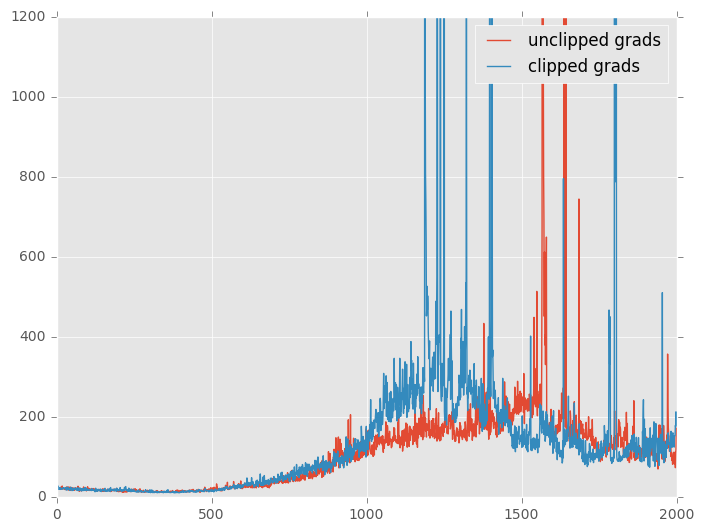

In [39]:
# Plot episodes length smoothed over 20 runs
plt.plot(np.mean(eps_length, axis=0), label='unclipped grads')
plt.plot(np.mean(eps_length_clipped, axis=0), label='clipped grads')
plt.legend()
plt.ylim(0, 1200)